In [1]:
#@title Packages
import functools

import jax
import jax.numpy as jnp
import numpy as onp
from sklearn.metrics.pairwise import rbf_kernel as rbf_sklearn
# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])
#@title Plot Functions

def plot_kernel_mat(K):
    # plot
    plt.figure()
    plt.imshow(K, cmap='Reds')
    plt.title(r'$K_{ff}$, (rbf)', fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()
    #@title Data

def get_1d_data(N=30, sigma_inputs=0.15, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-10, 10, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X))
    Y += sigma_obs * onp.random.randn(N)
    X += sigma_inputs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X_test = jnp.linspace(-11, 11, N_test) 
    X_test += sigma_inputs * onp.random.randn(N_test)

    X = X[:, None]
    X_test = X[:, None]

    assert X.shape == (N,1)
    assert Y.shape == (N,)

    return X, Y, X_test

def get_2d_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X1 = jnp.linspace(-10, 10, N)
    X2 = jnp.linspace(-5, 2, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X1)) + jnp.exp(X2)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X1_test = jnp.linspace(-11, 11, N_test)
    X2_test = jnp.linspace(-6, 4, N_test) 

    X = jnp.vstack((X1,X2)).T
    X_test = jnp.vstack((X1_test,X2_test)).T

    assert X.shape == (N,2)
    assert Y.shape == (N,)

    return X, Y, X_test

# Get Data
X, Y, X_test = get_1d_data(100, sigma_inputs=0.0, sigma_obs=0.1, N_test=100)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
#@title Kernel Functions

# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    return jnp.exp( - params['gamma'] * sqeuclidean_distance(x, y))
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

In [3]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X[:1, :]
test_Y = X[:1, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X.reshape(1, -1)), 
    onp.array(test_Y.reshape(1, -1)), 
    gamma=1.0
)
print(rbf_x_sk.shape, test_X.shape)

params = {'gamma': 1.0, 'var_f': 1.0}
gamma = 1.0
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = rbf_k_(
    test_X.squeeze(), 
    test_Y.squeeze()
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

(1, 1) (1, 2)


In [4]:
# Gram Matrix
def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

In [6]:
# map function 1
mapx1 = jax.vmap(lambda x, y: rbf_kernel(params, x, y), in_axes=(0, None), out_axes=0)

# test the mapping
x1_mapped = mapx1(X, X[0, :])

# Check output shapes, # of dimensions
assert x1_mapped.shape[0] == X.shape[0]   
assert jnp.ndim(x1_mapped) == 1   


mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)

K = mapx2(X, X)

# Check output shapes, # of dimensions
assert K.shape[0] == X.shape[0], X.shape[0]   
assert jnp.ndim(K) == 2     

rbf_x_sk = rbf_sklearn(X, X, 1.0)


onp.testing.assert_array_almost_equal(onp.array(rbf_x_sk), K)

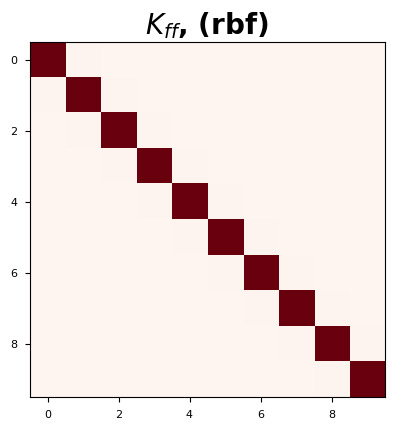

In [7]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X.copy()#[:2, :]
test_Y = X.copy() #[:2, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X), 
    onp.array(test_Y), 
    gamma=1.0
)

params = {'gamma': 1.0, 'var_f': 1.0}
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = covariance_matrix(
    rbf_k_,
    test_X, 
    test_Y
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

plot_kernel_mat(rbf_x)

In [8]:
#@title Tests

kx = rbf_kernel(params, X[0], X[0])

# check, the output should be 1.0
assert kx == 1.0, f"Output: {kx}"

kx = rbf_kernel(params, X[0], X[1])

# check, the output should NOT be 1.0
assert kx != 1.0, f"Output: {kx}"


# dk_dx = drbf_kernel(gamma, X[0], X[0])

# # check, the output should be 0.0
# assert dk_dx == 0.0, f"Output: {dk_dx}"

# dk_dx = drbf_kernel(gamma, X[0], X[1])

# # check, the output should NOT be 0.0
# assert dk_dx != 0.0, f"Output: {dk_dx}"

In [9]:
#@title Speed Test
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(x))(y)

rbf_K = functools.partial(rbf_kernel, params)
rbf_cov =  jax.jit(functools.partial(covariance_matrix, rbf_K))
rbf_x = rbf_cov(test_X,  test_Y)


rbf_cov2 =  jax.jit(functools.partial(gram, rbf_K))
rbf_x2 = rbf_cov2(test_X,  test_Y)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), onp.array(rbf_x2))

In [10]:
%timeit _ = rbf_cov(test_X,  test_Y)
%timeit _ = rbf_cov2(test_X,  test_Y)

5.69 µs ± 90 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.71 µs ± 95.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
X, Y, X_test = get_1d_data(10, sigma_obs=0.1)

test_X = X[0:1, :]
test_Y = X[1:2, :]

In [18]:
def drbf_kernel_scratch(gamma, X, Y):
    # initialize matrix
    dK_fg_ = onp.empty(X.shape[-1])
    
    constant = - 2 * gamma
    
    # calculate kernel matrix w. sklearn kernel
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    # loop through features/dimensions
    for idim in range(X.shape[1]):
        
        x_val = X[:, idim] - Y[:, idim]

        dK_fg_[idim] = constant * k_val *  x_val 
    return dK_fg_

In [19]:
dK_fg_ = drbf_kernel_scratch(gamma, test_X, test_Y)
rbf_kernel(params, test_X[0,:], test_Y[0,:])

Array(0.00287879, dtype=float32)

In [21]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

# calculate for a single sample
dK_fg = drbf_kernel_fg(params, test_X[0,:], test_Y[0,:])

# check theyre the same
assert dK_fg.all() == dK_fg_.all()

In [22]:
# generate some data
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

# extract a single sample
test_X = X[0:1, :]
test_Y = X[1:2, :]

In [23]:
dK_fg_ = drbf_kernel_scratch(gamma, test_X, test_Y)

In [24]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

# calculate for a single sample
dK_fg = drbf_kernel_fg(params, test_X[0,:], test_Y[0,:])

# check theyre the same
assert dK_fg.all() == dK_fg_.all()

In [25]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X
test_Y = X

In [26]:
dK_fg_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        dK_fg_[i, j, :] = drbf_kernel_scratch(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

In [27]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

K_func = functools.partial(drbf_kernel_fg, params)

# calculate kernel matrix
dK_fg = gram(K_func, test_X, test_Y)


# check
onp.testing.assert_array_almost_equal(onp.array(dK_fg), dK_fg_)

In [28]:
def d2rbf_kernel_scratch_jac(gamma, X, Y):
    d2K_fg2_ = onp.empty(X.shape[-1])
    
    constant = 2 * gamma
    
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        
        # compute the xterm: 2 gamma (xj - yj)^2
        x_val = constant * (X[:, idim] - Y[:, idim]) ** 2 - 1

        # compute the derivative term
        d2K_fg2_[idim] = constant * x_val * k_val 
    return d2K_fg2_

In [29]:
# initialize matrix
d2K_fg2_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        d2K_fg2_[i, j, :] = d2rbf_kernel_scratch_jac(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

In [30]:
# define the cross operator K_fg(x, y), dK wrt x
dK_fg_func = jax.hessian(rbf_kernel, argnums=(1))

# fix params for kernel function
K_func = functools.partial(dK_fg_func, params)

# calculate kernel matrix
d2K_fg2 = covariance_matrix(K_func, test_X, test_Y)

# get the diagonal terms
d2K_fg2 = jnp.diagonal(d2K_fg2, axis1=2, axis2=3)

d2K_fg2.shape

(10, 10, 2)

In [31]:
onp.testing.assert_array_almost_equal(onp.array(d2K_fg2), d2K_fg2_)